In [192]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
%matplotlib inline


# code to show how haufe-transformed feature weights are related to data covariance

In [193]:
def load_csv(csv_path):
    df = pd.read_csv(csv_path, header =0)
    return df

In [194]:
df = load_csv('~/GIT/archive/data.csv')

llvars = ['M1_CST', 'PMd_CST', 'PMv_CST','S1_CST','SMA_CST','preSMA_CST']

motor = df['NORMED_MOTOR']
lesion_load = df[llvars]


In [145]:
lesion_load

,M1_CST,PMd_CST,PMv_CST,S1_CST,SMA_CST,preSMA_CST
0,0.002082,0.102837,0.541656,0.010315,0.028453,0.052155
1,0.000925,0.014657,0.048664,0.000000,0.014622,0.009607
2,0.004280,0.039716,0.022745,0.000175,0.051176,0.076585
3,0.306340,0.400946,0.000000,0.034965,0.413357,0.446884
4,0.226516,0.161466,0.166623,0.234091,0.139103,0.167444
...,...,...,...,...,...,...
1015,0.035400,0.012057,0.038350,0.018881,0.030626,0.000000
1016,0.044655,0.074941,0.050780,0.055070,0.068168,0.073017
1017,0.206617,0.142553,0.588204,0.321678,0.114207,0.103761
1018,0.000000,0.000000,0.000000,0.011713,0.000000,0.000000


In [195]:
X_train, X_test, y_train, y_test = train_test_split(lesion_load, motor, test_size=0.2, random_state=42)

mdl = Ridge(normalize=True, max_iter=1000000, random_state=0)
mdl.fit(X_train, y_train)

coefs = mdl.coef_


### Haufe transformation:

$W$ = Regression coefficients

$\sum_x$ = Input data covariance

$\sum_{\hat{s}}^{-1}$ = Response data covariance (1-D) = single value


#### Formula for transformation:

$A = \sum_xW\sum_{\hat{s}}^{-1}$


In [203]:
# haufe feature transformation

# normalize X (in the same way that is done in Ridge)
X_train_norm = (X_train - np.mean(X_train))/np.linalg.norm(X_train,axis=0)

# data covariance
print('X_train shape {}'.format(X_train_norm.shape))
cov_x=np.cov(np.transpose(X_train_norm))

# predictor covariance
print('y_train shape {}'.format(y_train.shape))
cov_y=np.cov(np.transpose(y_train))

beta_coeffs = mdl.coef_

weight=beta_coeffs

haufe_activation=np.matmul(cov_x,weight)*(1/cov_y)

X_train shape (816, 6)
y_train shape (816,)


In [204]:
X_train_norm

,M1_CST,PMd_CST,PMv_CST,S1_CST,SMA_CST,preSMA_CST
743,0.040640,0.050389,0.114422,0.047275,0.054695,0.055389
137,-0.005270,0.009355,-0.005304,-0.002453,0.010639,0.014018
799,-0.009400,-0.007551,-0.009207,-0.014731,0.003162,-0.008763
933,-0.019291,-0.017982,-0.017921,-0.018653,-0.018463,-0.016181
822,-0.003843,-0.014199,-0.007165,-0.012787,-0.010296,-0.014785
...,...,...,...,...,...,...
106,-0.011210,-0.005546,-0.009298,-0.016334,0.001609,-0.006057
270,-0.019291,-0.017982,-0.017921,-0.018653,-0.018463,-0.016181
860,-0.015926,-0.014830,-0.015879,-0.013333,-0.015300,-0.011468
435,-0.010789,-0.003855,0.004704,-0.013179,-0.015530,-0.015876


In [205]:
haufe_activation

array([-0.00834436, -0.00919669, -0.00736092, -0.00769353, -0.00894546,
       -0.00862362])

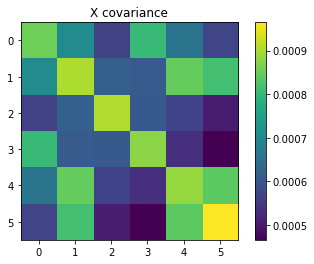

In [206]:
plt.imshow(cov_x)
plt.title('X covariance')
plt.colorbar()

Text(0.5, 1.0, 'haufe activ. weights (abs val)')

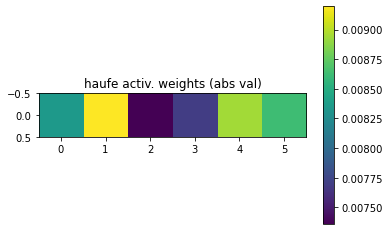

In [207]:
haufe = np.reshape(haufe_activation*-1, [1, 6])
plt.imshow(haufe)
plt.colorbar()
plt.title('haufe activ. weights (abs val)')

Text(0.5, 1.0, 'avg. covariance')

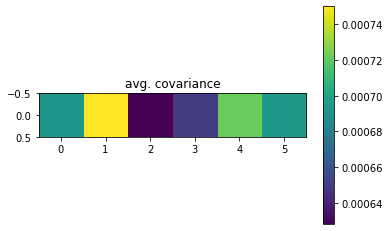

In [208]:
avg_cov = np.reshape(np.mean(cov_x,axis=0), [1, 6])
plt.imshow(avg_cov)
plt.colorbar()
plt.title('avg. covariance')

Text(0.5, 1.0, 'betas (abs val)')

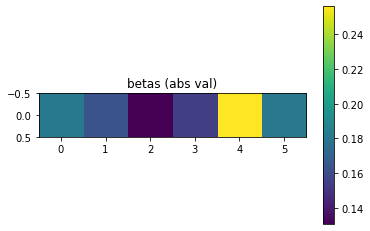

In [209]:
betas = np.reshape(mdl.coef_*-1, [1, 6])
plt.imshow(betas)
plt.colorbar()
plt.title('betas (abs val)')

In [210]:
print(np.corrcoef(avg_cov, haufe))

print(avg_cov)
print(haufe)

[[1.         0.98676316]
 [0.98676316 1.        ]]
[[0.00069257 0.00075008 0.00062819 0.00065011 0.00072158 0.00069359]]
[[0.00834436 0.00919669 0.00736092 0.00769353 0.00894546 0.00862362]]
